# Exercise 2.1

_In ε-greedy action selection, for the case of two actions and ε = 0.5, what is the probability that the greedy action is selected?_

In such a case there is 0.5 chance that we go greedy, and there is another 0.5 chance that we will randomly sample with equal probability (= 0.5) one of the two actions. It is important to note that even in this case it is very much possible that the greedy action is still chosen. In this case that is 0.5 \* 0.5 chance. So in total this is 0.5 + 0.5 * 0.5 = 0.75

# Exercise 2.2: Bandit Example

_Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using ε-greedy action selection sample-average action-value estimates, and initial estimates of Q1(a) = 0, for all a. Suppose the initial sequence of actions and rewards is A1 =1,R1 =1,A2 =2,R2 =1,A3 =2,R3 =2,A4 =2,R4 =2, A5 = 3, R5 = 0. On some of these time steps the ε case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?_

I believe that it **could** have occurred at any time step since random selection selects draws from the entire action space it is impossible to know when it definitely did not occur.

It is however possible to know when it has definitely occurred, because an action has been chosen that does not have the highest value at that point in time.

**t=1:** All actions are equal here, so the result would have been the same whether or not it was epsilon greedy, so not able to certainly tell the difference.

**t=2:** Definitely an epsilon case as the actual highest value method at this point is A1 with a value of 1 as was discovered at the previous time step.

**t=3:** Could have been both as the A=1 and A=2 both have a value of 1 at this point.

**t=4:** Could have been both, it went for the highest valued action, but that could also have happened randomly in the epsilon case.

**t=5:** A=3 would at this point still be valued at its default value of 0, meaning it would not be the highest one. It could only have been chosen while exploring in the epsilon case.

**To summarize : ** 2 and 5 are definitely epsilon cases, the other ones might be both.


# Exercise 2.3

_In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively._

In the long run the algorithm with the lowest non-zero epsilon will do best. In fact, an algorithm with $\epsilon=0$ would do best if it choose the best action right from the start. In the case of Figure 2.2 this is not the case however as it flat-lines at a very low percentage. The algorithm with $\epsilon=0.01$ in this case will do best. As the number of steps goes to infinity, it will find the best action and then choose that action with 0.99 probability, which is higher than the $\epsilon=0.1$ case which will choose the best one with 0.9 probability.

# Exercise 2.4 

_If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?_

Equation 2.6 states :

$Q_{n+1} = Q_n + \alpha\bigg[R_n - Q_n\bigg]$ 

In the case of a non-constant $\alpha$ such as when using a decaying value, we would get an alpha value parameterized by $n$, as such:

$Q_{n+1} = Q_n + \alpha_n\bigg[R_n - Q_n\bigg]$ 

** Todo: simplify further **

# Exercise 2.5 (programming) 

Design and conduct an experiment to demonstrate the difficulties that sample-average
methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all 
the q∗(a) start out equal and then take independent random walks (say by adding a normally distributed 
increment with mean zero and standard deviation 0.01 to all the q∗(a) on each step). 

Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and 
another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, 
say of 10,000 steps.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from collections import defaultdict   
from IPython.core.debugger import set_trace

# Parameters for the bandit problem

K = 10
alpha = 0.1
epsilon = 0.1

start_val = 1

# The actual values that our algorithm is not supposed to see
# qs = np.ones(K) * start_val

# def gen_random_qs():
    

# qs = np.random.normal(0, K, K)

# print("Qs = ", qs)


# print(max_Q = )
# qs = [0.2, 1]

In [12]:
class BanditProblem(object):
    
    def __init__(self, Qs, Q_drift=0):
        self.Qs = Qs # The Q-value of each bandit
        self.action_space = range(len(Qs))
        
        self.Q_drift = Q_drift
        
    def _reward(self, act):
        return self.Qs[act]
        
    def step(self, act):
        
        if type(self.Q_drift) is np.ndarray:
            self.Qs += self.Q_drift
        elif self.Q_drift != 0:
            self.Qs += np.random.normal(0, self.Q_drift, len(self.Qs))
        
        return {}, self._reward(act)
    
    def mean_Q(self):
        return np.mean(self.Qs)
    
    def min_Q(self):
        return np.min(self.Qs)
    
    def max_Q(self):
        return np.max(self.Qs)
    
    def __str__(self):
        return f"BanditProblem [minQ, meanQ, maxQ = {self.min_Q():.2f}, {self.mean_Q():.2f}, {self.max_Q():.2f}]"
        


class ActionValueSolver(object):

    def __init__(self, env, epsilon, default_val=0, epsilon_increment=0, verbosity=False):
                
        self.env = env
        self.Q_est = np.ones(len(env.action_space)) * default_val
        self.epsilon = epsilon
        
        self.rewards = list()
        self.avg_rewards = list()
        self.cum_reward = 0
        self.default_val = default_val
        
        self.k_counts = defaultdict(int)
        self.epsilon_increment = epsilon_increment
        
        self.step_nr = 0

    def sample_k(self):
        r = random.random()
        if r < self.epsilon: # Randomly sample
            q_indices = range(len(self.Q_est))
        else: # Epsilon greedy
            q_indices = np.where(self.Q_est == np.max(self.Q_est))[0]

        k_sample = np.random.choice(q_indices, 1)[0]

        return k_sample
    
    def solve(self, steps):
        for i in range(steps):
            self.step()

class SampleAvgEstimator(ActionValueSolver):
    
    def __init__(self, env, epsilon, default_val=0, epsilon_increment=0, verbosity=False):  
        super(SampleAvgEstimator, self).__init__(env, epsilon, default_val=default_val, epsilon_increment=epsilon_increment, verbosity=verbosity)
    
    def step(self):
        k = self.sample_k()

        new_Q = self.q_sample_average(k)
        self.Q_est[k] = new_Q
        
        self.cum_reward += new_Q
        self.avg_rewards.append(self.cum_reward / (self.step_nr + 1))
        
        self.step_nr += 1
        self.epsilon += self.epsilon_increment
        
        self.epsilon = max(min(self.epsilon, 1), 0)
    
    def q_sample_average(self, k):
        _, reward = self.env.step(k)
        
        k_count = self.k_counts[k]
       
        Q_est_k = self.Q_est[k]
        val = Q_est_k + 1 / (k_count + 1) * (reward - Q_est_k)
        
        self.k_counts[k] = k_count + 1
        
        return val
            

BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]


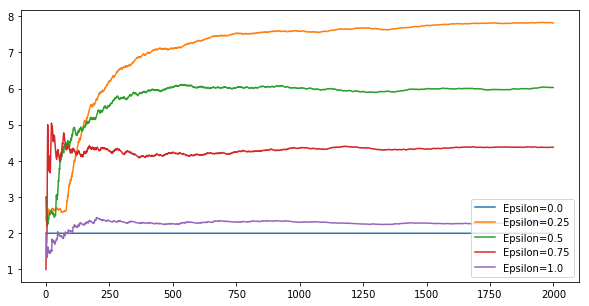

In [5]:
def run_experiments(env):

    i = 1
    print(env)
    plt.figure(figsize=(10,5)) 
    max_steps = 2000

    for ep in np.linspace(0, 1.0, num=5):

        i+=1
        est = SampleAvgEstimator(env, ep)
        print(str(est))
        est.solve(max_steps)
        plt.plot(est.avg_rewards, label=f"Epsilon={ep}")



    plt.legend(loc=4)
    


# K_bandits = 10
# env = BanditProblem(np.random.normal(0, K_bandits, K_bandits))
env = BanditProblem([1, 1, 1, 2, 2, 3, 10, 3, 2, 2, 1, 1, 1])
run_experiments(env)


BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]
BanditProblem [minQ, meanQ, maxQ = -10.00, 19.23, 23.00]
BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]
BanditProblem [minQ, meanQ, maxQ = -10.00, 19.23, 23.00]
BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]
BanditProblem [minQ, meanQ, maxQ = -10.00, 19.23, 23.00]
BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]
BanditProblem [minQ, meanQ, maxQ = -10.00, 19.23, 23.00]
BanditProblem [minQ, meanQ, maxQ = 1.00, 2.31, 10.00]
BanditProblem [minQ, meanQ, maxQ = -10.00, 19.23, 23.00]


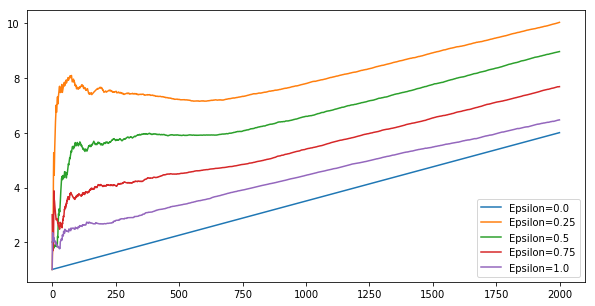

In [6]:
def run_experiments_drift(env, drift):

    i = 1
    
    plt.figure(figsize=(10,5)) 
    max_steps = 2000

    for ep in np.linspace(0, 1.0, num=5):
        env = BanditProblem([1, 1, 1, 2, 2, 3, 10, 3, 2, 2, 1, 1, 1], 
#                             Q_drift=np.array([0,0,0,0,0,0,-0.01,0,0,0,0,0,0,]))
#                             Q_drift=np.array([0.01,0.01,0.01,0.01,0.01,0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01]))
                            Q_drift=np.array([drift,drift,drift,drift,drift,drift,-drift,drift,drift,drift,drift,drift,drift]))
        print(env)
        i+=1
        est = SampleAvgEstimator(env, ep)
        print(str(est))
        est.solve(max_steps)
        plt.plot(est.avg_rewards, label=f"Epsilon={ep}")

        print(env)

    plt.legend(loc=4)

run_experiments_drift(env, 0.01)

In [ ]:
# With decaying epsilon

def run_experiments_decay(env, decay):

    i = 1
    print(env)
    plt.figure(figsize=(10,5)) 
    max_steps = 2000

    for ep in np.linspace(0, 1.0, num=9):
    #     env = BanditProblem(range(1,K_bandits+1))


        print("-"*57)
        print(f"|\t\t\tEXPERIMENT #{i}\t\t\t|")
        print("-"*57)

        print()

        i+=1
        est = SampleAvgEstimator(env, ep, epsilon_increment=decay)
        print(str(est))
        est.solve(max_steps)
        plt.plot(est.avg_rewards, label=f"Epsilon={ep}")

    plt.legend(loc=4)
    
env = BanditProblem([1, 1, 1, 2, 2, 3, 10, 3, 2, 2, 1, 1, 1])
run_experiments_decay(env, 0.0001)

In [60]:
class StepSizeEstimator(ActionValueSolver):
    
    def __init__(self, env, epsilon, alpha, default_val=0, epsilon_increment=0, verbosity=False):  
        super(StepSizeEstimator, self).__init__(env, epsilon, default_val=default_val, epsilon_increment=epsilon_increment, verbosity=verbosity)
        self.alpha = alpha
        
        self.past_rewards = np.tile([0], (len(env.action_space), 1))
        
        print(self.past_rewards.shape)
        print("E",len(env.action_space))
        self.Q_est = None # We don't need this one, unless perhaps if we use different default Q values
        
        
    def discarded_past_rewards(self):
        
        discarded_sum = (1-self.alpha) ** self.step_nr * self.default_val
        print("step_nr = ", self.step_nr)
        print("discarded_sum = ", discarded_sum)
        for i in range(1, self.step_nr):
            discarded_sum += self.alpha * (1 - self.alpha) ** (self.step_nr - i)
            
        return discarded_sum
    
    def step(self):
        k = self.sample_k()

        _, reward = self.env.step(k)
        
        print("Reward = ", reward)
        
        new_Q = self.discarded_past_rewards()
        print("new_Q = ", new_Q)
        print("Chosen K = ", k)
        
        # Add zeros to all other Q's in order to keep the alpha decay param synchronized across all Q values
        for i in range(len(self.past_rewards)):
            print(f"*** i={i} => ", self.past_rewards[i])
            
            test = np.append(self.past_rewards[i], 1298)
            print("test = ", test)
            self.past_rewards[i] = test
#             if i != k:
#                 print("NOT K")
                
# #                 news=np.append(self.past_rewards[i], reward)
# #                 print("news=",news)
# #                 self.past_rewards[i] = news
# #                 print(self.past_rewards[i])
# #                 print(np.append(self.past_rewards[i], 0, axis=1))
# #                 self.past_rewards[i] = np.append(self.past_rewards[i], 0)
#             else:
#                 self.past_rewards[i] = np.append(self.past_rewards[i], reward)
                
        print("Past Rewards")
        print(self.past_rewards.shape)
        print(self.past_rewards)
        
        self.cum_reward += new_Q
        self.avg_rewards.append(self.cum_reward / (self.step_nr + 1))
        
        self.step_nr += 1
        self.epsilon += self.epsilon_increment
        
        # Clamp to [0, 1]
        self.epsilon = max(min(self.epsilon, 1), 0)

test_env = BanditProblem([1])
sse = StepSizeEstimator(test_env, 0, 0.99)

for i in range(3):
    sse.step()

(1, 1)
E 1
Reward =  1
step_nr =  0
discarded_sum =  0.0
new_Q =  0.0
Chosen K =  0
*** i=0 =>  [0]
test =  [   0 1298]


ValueError: could not broadcast input array from shape (2) into shape (1)